# Final Project- Machine Learning: Neural Network 

- In this final project, we will be creating a neural network system based on NumPy that would be able to recgonized handwwritten numbers. 

### Preparing the Data: 

- The first thing we need to do is load our data to our notebook. The dataset that we will be using here is a popular dataset from Modified National Institue of Standards and Technology (MNIST) database. The dataset contains 70000 28X28 images of handwritten digits.

- A very important part of preparing the data is turning the y values (in this case, labels 0 to 9), which are categorical, to binary numbers that the computer will better understand. This will be done through one-hot encoding.

- Once this is done, we can now split the data into training (first 60000 images) and test data(last 10000).

- Now that are data is prepared, we can now proceed to building our model. 

In [120]:
from sklearn.datasets import fetch_mldata
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")


mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"] #x values: 70000 images w/pixels
                                      #y values: labels (0-9)

# scale
X = X / 255
digits = 10
examples = y.shape[0]

#one-hot encoding
y = y.reshape(1, examples)
Y_new = np.eye(digits)[y.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

#split data to training and test sets
m = 60000
m_test = X.shape[0] - m
X_train, X_test = X[:m].T, X[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]

#shuffle data set; helps with convergence of cost function
shuffle_index = np.random.permutation(m)
X_train= X_train[:, shuffle_index]
Y_train = Y_train[:, shuffle_index]

- Let's visualize the data!
- The following plot(code can be seen on my github), shows the most important features of the dataset that would differentiate the different classes.
- Looking at the picture we can tell that we have 10 different classes, which means that we are dealing with a multiclass classification problem. 

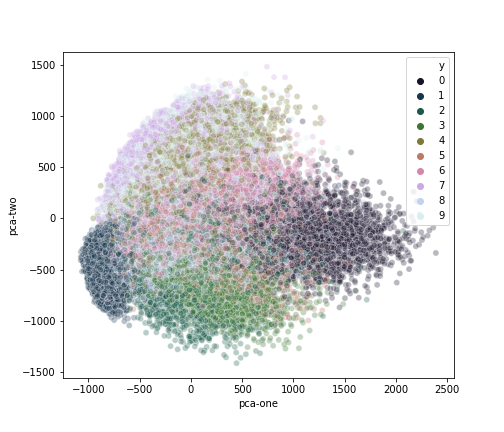

In [99]:
from IPython.display import Image
Image(filename='PCA.png') 

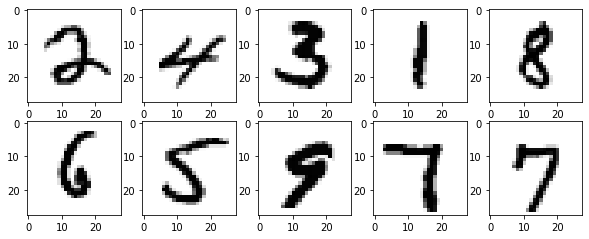

In [121]:
plt.figure(figsize=(10,10))
X=X[shuffle_index]
for i in range(0,10):
    plt.subplot(5,5,i+1)
    img= X[i].reshape((28,28))
    plt.imshow(img, interpolation="none", cmap="Greys")

- Before training our model, let's first define helper functions that we would use to train our model. These two functions that we'll be defining are activation and cost functions. 
- There are many types of activation functions. Below are some examples:
                    1. ReLu
                    2. Tanh
                    3. Sigmoid
- For our specific problem we would be using the sigmoid function:

$$ \phi (z) = \frac{1}{1 + \exp^(-z)}$$

- The role of the activation function is to introduce non-linearity to our network. Activation functions convert input signal to an output signal. 
- The sigmoid function is good to use since it exists between 0 to 1, just like probability. 
- Since we are dealing with a multiclass classification, we will also use the Softmax Function in the output layer. 

$$ Softmax(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

In [122]:
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

### Cost Function

- The cost function's role is to determine "how good" a network did with respect to it's training sample and the expected output. 
- Similar to the activation function, there are also several types of cost functions:
                            1. Quadratic cost
                            2. Cross Entropy cost
                            3. Exponential cost
- In this particular model, we will ust the cross entropy function: 

$$ H_p(q)= \sum{c=1}^Cq(y_c)*log(p(y_c))$$

In [123]:
def cross_entropy(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1./m) * L_sum

    return L

- Since we've now defined both the activation and cost functions, we are now ready to train our model.
- It is important to note that neural network algorithm has three main parts:
                    1. Initialization of parameters
                    2. Forward propagation
                    3. Back propagation

1. Initialization of Parameters:
- it is important that starting weights are randomized because the gradient based methods commonly used to train neural networks do not work well when all of the weights are initialized to the same value.


2. Forward propagation:
- The inputs provide the initial information that propagates to hidden units at each layers and produce the ouput.Each hidden layer accepts the input data, processes it as per the activation function and passes to the successive layer.
- the forward pass on a single example x executes the following:

$$ \hat{y}= \sigma(w^Tx +b),$$

where $\hat{y}$ is the output, $\sigma$ is the activation function, $w$ is weight, and $b$ is bias

3. Backward propagation:
- After computing the total cost, we want to improve the performance of the neural network on the training data, so that we can change the weights and bias, and hopefully, lower the total cost. We want to know how much the specific weights and bias affect the total cost, so we need to calculate the partial derivatives of the total cost with respect to the weights and bias. To do this we will use the chain rule. 

$$ \frac{\partial{C}}{\partial{w}}= \frac{\partial{C}}{\partial{\hat{y}}  $$

- After calculating the partial derivatives with respect to the cost, we can now update the weights and bias, by multiplying the learning rate and substracting the results from the weights and bias:

$$ W_1= W_1- (\alpha \times\frac{\partial{C}}{\partial{W_1}})$$

- This optimization technique can be referred to as batch gradient descent

## Training

- Let's write a code to predict the numbers of the images in the dataset. We will be using the batch gradient descent optimization for this. 

In [125]:
def batchANN(X_train, Y_train, X_test, Y_test,
             n_h, n_classes, #(number of hidden units, number of outputs)
            learning_rate, epoch, #epoch- number of iterations
             matrix=False, plot= False): 
    
    start_time=time.time() #time execution 
    
    #intialize parameters 
    n_x = X_train.shape[0]
    W1 = np.random.randn(n_h, n_x) 
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_classes, n_h)
    b2 = np.zeros((n_classes, 1))

    X = X_train
    Y = Y_train
    
    x_plot = [] #store epochs
    y_plot = [] #store costs

    for i in range(epoch):

        #forward propagation
        Z1 = np.matmul(W1, X) + b1
        A1= sigmoid(Z1)
        Z2= np.matmul(W2, A1) + b2
        A2= np.exp(Z2) / np.sum(np.exp(Z2), axis=0)
        
        #compute cost
        cost = cross_entropy(Y, A2)
        
        #back propagation
        dZ2 = A2-Y
        dW2 = (1./m) * np.matmul(dZ2, A1.T)
        db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(W2.T, dZ2)
        dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
        dW1 = (1./m) * np.dot(dZ1, X.T)
        db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)

        #update parameters 
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        
        """Plotting Epochs vs. Cost"""
        
        if plot==True:

            if (i % 100 == 0):
                print("Epoch", i, "cost: ", cost)
                
            x_plot.append(i)
            y_plot.append(cost)
        
        end_time=time.time()
        total_time= end_time-start_time
            
    if plot == True:
        plt.plot(x_plot, y_plot, color="red", marker='o')
        plt.show()
        
    """Plotting Confusion Matrix"""
        
    if matrix== True:
            
        Z1 = np.matmul(W1, X_test) + b1
        A1 = sigmoid(Z1)
        Z2 = np.matmul(W2, A1) + b2
        A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

        predictions = np.argmax(A2, axis=0)
        labels = np.argmax(Y_test, axis=0)

        cm= confusion_matrix(predictions, labels)
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, cmap="YlGnBu")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        print(classification_report(predictions, labels))
    
        plt.show()
    
    print("Total Time:" ,total_time)
    print("Final cost:", cost)

Epoch 0 cost:  7.954082917183613


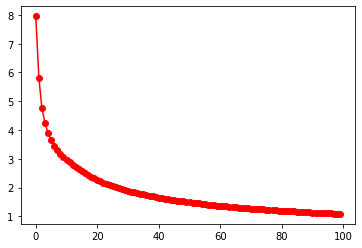

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       995
           1       0.90      0.86      0.88      1183
           2       0.63      0.63      0.63      1037
           3       0.67      0.65      0.66      1039
           4       0.61      0.64      0.62       933
           5       0.48      0.53      0.50       806
           6       0.74      0.70      0.72      1013
           7       0.73      0.74      0.74      1017
           8       0.52      0.57      0.54       896
           9       0.61      0.57      0.59      1081

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.68      0.67      0.67     10000



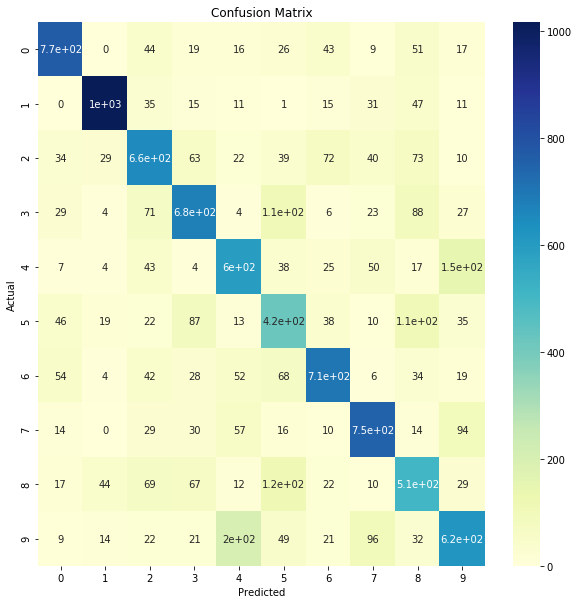

Total Time: 37.44256091117859
Final cost: 1.0846752257405856


In [126]:
result= batchANN(X_train, Y_train, 
                 X_test,Y_test,
                 n_h=50, n_classes=10, 
                 learning_rate=.5, epoch=100, matrix=True, plot=True)

- Looking at the accuracy and total cost, the batch optimization method is clearly not efficient, given the number of iterations. Analyzing the confusion matrix suggests that the model has predicted many wrong outputs. 
- In order to better minimize the cost function, we can switch from batch gradient descent to mini-batch gradient descent.It is a variation of the gradient descent algorithm that splits the training dataset into small batches that are used to calculate model error and update model coefficients.
- Before implementing the mini-batch gradient descent, let's define feed propagation and back propgation as functions. 

In [9]:
def ff(X, parameter):
    Z1 = np.matmul(parameter["W1"], X) + parameter["b1"]
    A1 = sigmoid(Z1)
    Z2 = np.matmul(parameter["W2"], A1) + parameter["b2"]
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

    ff_dict= {"Z1":Z1,
              "A1": A1,
              "Z2": Z2,
              "A2": A2}
    
    return ff_dict

In [10]:
def back_prop(X, Y, parameter, ff_dict, m_batch):
        
    dZ2 = ff_dict["A2"] - Y
    dW2 = (1./m_batch) * np.matmul(dZ2, ff_dict["A1"].T)
    db2 = (1./m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(parameter["W2"].T, dZ2)
    dZ1 = dA1 * sigmoid(ff_dict["Z1"]) * (1 - sigmoid(ff_dict["Z1"]))
    dW1 = (1./m_batch) * np.matmul(dZ1, X.T)
    db1 = (1./m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    gradient = {"dW1": dW1,
                "db1": db1,
                "dW2": dW2,
                "db2": db2}

    return gradient

In [11]:
def mb(gradient, beta, v_dW1,v_db1,v_dW2, v_db2):

    v_dW1 = (beta * v_dW1 + (1. - beta) * gradient["dW1"])
    v_db1 = (beta * v_db1 + (1. - beta) * gradient["db1"])
    v_dW2 = (beta * v_dW2 + (1. - beta) * gradient["dW2"])
    v_db2 = (beta * v_db2 + (1. - beta) * gradient["db2"])
        
    mbs= {"v_dW1": v_dW1,
          "v_db1": v_db1,
          "v_dW2": v_dW2,
          "v_db2": v_db2}
        
    return mbs

## Training with Mini-Batch

In [136]:
from sklearn.metrics import accuracy_score
import time

def mbANN(X_train, Y_train, 
          X_test, Y_test,            
          learning_rate,
          n_h, epoch, 
          matrix= False,
          plot= False):
    
    start_time=time.time()
    
    beta=.9
    batch_size=128
    np.random.seed(138)
    n_x = X_train.shape[0]
    
    #initialize parameters
    parameter = { "W1": np.random.randn(n_h, n_x)* np.sqrt(1. / n_x),
                  "b1": np.zeros((n_h, 1))* np.sqrt(1. / n_x),
                  "W2": np.random.randn(digits, n_h)* np.sqrt(1. / n_h),
                  "b2": np.zeros((digits, 1))* np.sqrt(1. / n_h)}
    
    #calculate number of batches

    batches = -(-m // batch_size)
                
    result = []
    
    #initialize 

    v_dW1 = np.zeros(parameter["W1"].shape)
    v_db1 = np.zeros(parameter["b1"].shape)
    v_dW2 = np.zeros(parameter["W2"].shape)
    v_db2 = np.zeros(parameter["b2"].shape)

    for i in range(epoch):
        
        #reshuffle 
        
        permutation = np.random.permutation(X_train.shape[1])
        X_train_shuffled = X_train[:, permutation]
        Y_train_shuffled = Y_train[:, permutation]

        for j in range(batches):
            
            #caculate mini batches
            begin = j * batch_size
            end = min(begin + batch_size, X_train.shape[1] - 1)
            X = X_train_shuffled[:, begin:end]
            Y = Y_train_shuffled[:, begin:end]
            m_batch = end - begin

            #forward propagation, back propagation
            ff_dict = ff(X, parameter)
            gradient = back_prop(X, Y, parameter, ff_dict, m_batch)
            mbs= mb(gradient, beta, v_dW1,v_db1,v_dW2, v_db2)
            
            #update parameters 
            parameter["W1"] = parameter["W1"] - learning_rate * mbs["v_dW1"]
            parameter["b1"] = parameter["b1"] - learning_rate * mbs["v_db1"]
            parameter["W2"] = parameter["W2"] - learning_rate * mbs["v_dW2"]
            parameter["b2"] = parameter["b2"] - learning_rate * mbs["v_db2"]
         
        #run test datasets
        ff_dict = ff(X_train, parameter)
        train_cost = cross_entropy(Y_train, ff_dict["A2"])
        test_ff = ff(X_test, parameter)
        test_cost = cross_entropy(Y_test, test_ff["A2"])

        #test the accuracy
        train_predictions = np.array(np.argmax(ff_dict["A2"], axis=0))
        train_labels = np.array(np.argmax(Y_train, axis=0))
        train_accuracy= np.mean(np.equal(train_labels, train_predictions))*100
        
        predictions = np.array(np.argmax(test_ff["A2"], axis=0))
        labels = np.array(np.argmax(Y_test, axis=0))
        test_accuracy = np.mean(np.equal(labels, predictions))*100
        
        end_time=time.time()
        total_time= end_time-start_time
        
        result.append((i, train_cost, test_cost, test_accuracy, train_accuracy))
    
    '''""Plot Accuracy vs. Epochs""'''
    
    if plot==True:
        train_epoch_list= list((zz[0] for zz in result))
        train_accuracy_list = list((zz[4] for zz in result))
        test_epoch_list = list((zz[0] for zz in result))
        test_accuracy_list = list((zz[3] for zz in result))
        plt.figure(figsize=(12,5))
        plt.title("Accuracy vs. Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.plot(test_epoch_list, test_accuracy_list, color="red",marker='d', label="Test")
        plt.plot(train_epoch_list, train_accuracy_list, color="b",
                marker='o', linestyle='dashed', label="Training")
        plt.legend(loc="upper left")

        
        plt.show()
        
    """""""Plot Confusion Matrix"""""""
    if matrix== True:
        ff_dict = ff(X_test, parameter)
        predictions = np.argmax(ff_dict["A2"], axis=0)
        labels = np.argmax(Y_test, axis=0)

        cm= confusion_matrix(predictions, labels)
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, cmap="YlGnBu")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        print(classification_report(predictions, labels))
        plt.show()

                
    print("Total Time:", total_time)
    print("Final train cost:", test_cost, "       ","Final test cost:", train_cost)
    print("Done.","\n")
    return result

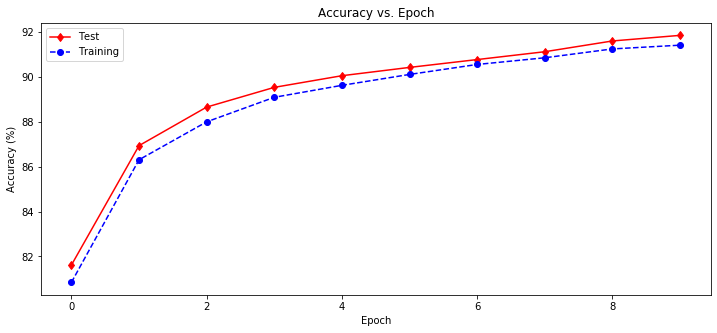

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1024
           1       0.98      0.96      0.97      1151
           2       0.89      0.93      0.91       990
           3       0.91      0.89      0.90      1032
           4       0.93      0.91      0.92       999
           5       0.86      0.91      0.88       843
           6       0.94      0.93      0.93       971
           7       0.92      0.93      0.92      1007
           8       0.88      0.89      0.88       970
           9       0.90      0.90      0.90      1013

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



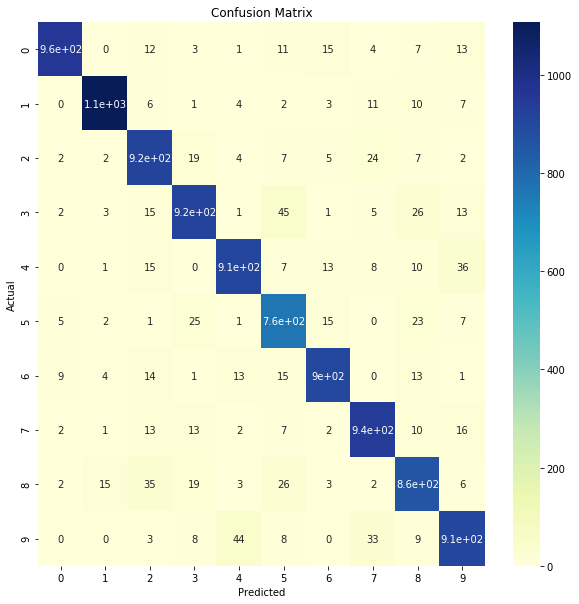

Total Time: 10.219666957855225
Final train cost: 0.2952335213973224         Final test cost: 0.30385526727229695
Done. 



In [137]:
train1= mbANN(X_train, Y_train,X_test, Y_test,
      learning_rate=.5,n_h=50,epoch=10, matrix=True, plot=True)

- With the same hyperparameters(except # of epochs), after changing the optimization method, the cost function converges much faster than the previous technique, and in fewer epochs!
- 93% accuracy and test and training costs around .3 are not bad, but we can do better by tuning some hyperparameters!

### Hyperparameter tuning

- Hyperparameters are variables that determine the network structure and how the network is trained. Hyperparameters are set BEFORE training. In this project, we'll be looking specifically into the number of units in the hidden layer, and learning rate. 

##### Number of Hidden Units in a Hidden Layer

- The hidden layer is the layer in between the input and output layer. 
- A small number of units can cause underfitting. 
- Many hidden units within a layer can increase accuracy. 

Number of Hidden Units: 1
Total Time: 4.541866302490234
Final train cost: 1.7431476612050538         Final test cost: 1.7305717831378384
Done. 

Number of Hidden Units: 21
Total Time: 7.920375108718872
Final train cost: 0.18697290433191802         Final test cost: 0.17177162894171247
Done. 

Number of Hidden Units: 41
Total Time: 10.837084293365479
Final train cost: 0.1519054107386974         Final test cost: 0.14214030620211915
Done. 

Number of Hidden Units: 61
Total Time: 12.305041313171387
Final train cost: 0.13335308529844953         Final test cost: 0.1284024869836345
Done. 

Number of Hidden Units: 81
Total Time: 14.411478042602539
Final train cost: 0.13657449696290394         Final test cost: 0.12726884943981104
Done. 



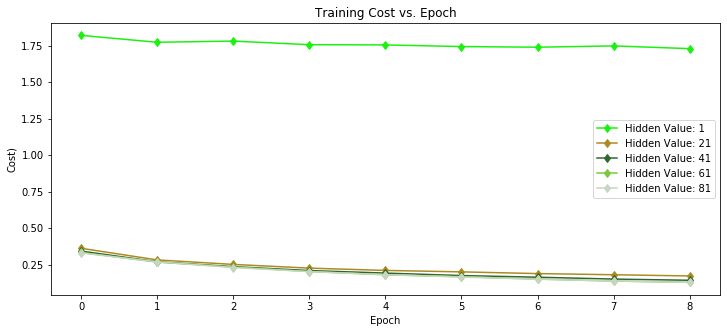

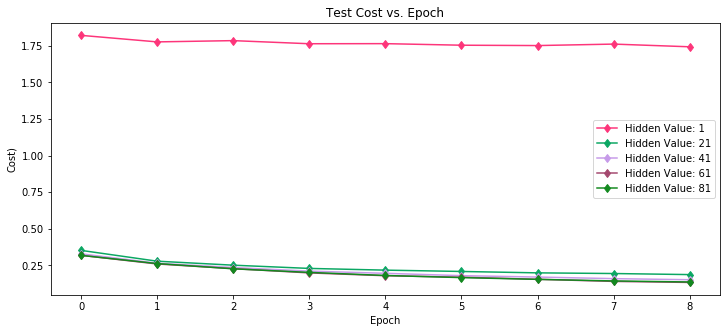

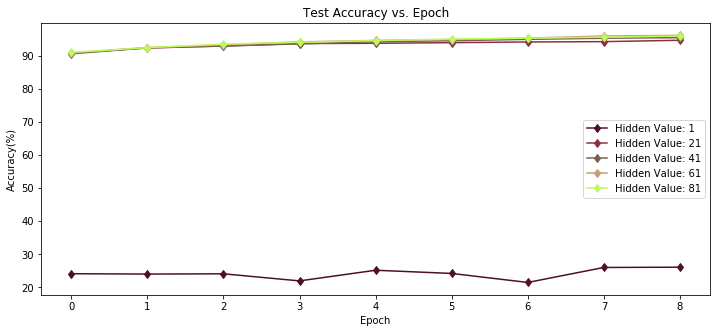

In [53]:
import random

"""Plot cost and accuracy while varying 

   the number of hidden units"""

def random_color():
    r = random.randint(0,255)/255.0
    g = random.randint(0,255)/255.0
    b = random.randint(0,255)/255.0
    return [r,g,b, 1.0]

hidden = np.arange(1, 100 + 1, step=20, dtype="int")

results = []
for value in hidden:
    print("Number of Hidden Units:", value)
    result = mbANN(X_train, Y_train,
                   X_test, Y_test,
                 learning_rate=4,
                 n_h=value,
                 beta=.9,
                 batch_size=128,
                 epoch=9,
                 matrix=False)
    
    results.append((value, result))

plt.figure(figsize=(12,5))
plt.title("Training Cost vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cost)")
for i in range(len(results)):
    epoch_list=[]
    tr_cost_list=[]
    
    __hidden_value = results[i][0]
    for bbb in results[i][1]:
        __epoch = bbb[0]
        __train_cost = bbb[1]

        epoch_list.append(__epoch)
        tr_cost_list.append(__train_cost)
        
   
    plt.plot(epoch_list,tr_cost_list, '-d', color=random_color(), label="Hidden Value: " + str(__hidden_value))
     
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(12,5))
plt.title("Test Cost vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cost)")
for i in range(len(results)):
    epoch_list=[]
    ts_cost_list=[]

    __hidden_value = results[i][0]
    for bbb in results[i][1]:
        __epoch = bbb[0]
        __test_cost = bbb[2]

        epoch_list.append(__epoch)
        ts_cost_list.append(__test_cost)

    plt.plot(epoch_list,ts_cost_list, '-d', color= random_color(), label="Hidden Value: " + str(__hidden_value))
  
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(12,5))
plt.title("Test Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
for i in range(len(results)):
    epoch_list=[]
    acc_list=[]

    __hidden_value = results[i][0]
    for bbb in results[i][1]:
        __epoch = bbb[0]
        _acc = bbb[3]

        epoch_list.append(__epoch)
        acc_list.append(_acc)

    plt.plot(epoch_list,acc_list, '-d', color= random_color(), label="Hidden Value: " + str(__hidden_value))

plt.legend(loc="best")
plt.show()

- As you can see in the graphs, having only 1 hidden unit is not accurate or efficient at all. However, hidden units between 20-100 don't seem to have much difference.
- For this project, we will use 75 units for our hyperparameter. If you look at the training cost between 61 and 81 units, 61 has a smaller cost. 

##### Learning Rate

- Now that we've chosen the best number for our hidden units, we'll now focus on the learning rate.
- The learning rate defines how quickly a network updates its parameters.
- If learning rate is low, training will progress very slowly.
- If learning rate is too large, training might not converge. 

LR: .001
Total Time: 10.744680881500244
Final train cost: 2.3060085600956715         Final test cost: 2.305168577219493
Done. 

LR: .01
Total Time: 10.767755031585693
Final train cost: 2.0046016282157626         Final test cost: 2.008832008742616
Done. 

LR: .1
Total Time: 10.264938116073608
Final train cost: 0.6146314668024857         Final test cost: 0.6323922838991939
Done. 

LR: 1.0
Total Time: 10.411981105804443
Final train cost: 0.24606871506661288         Final test cost: 0.25065870522166483
Done. 



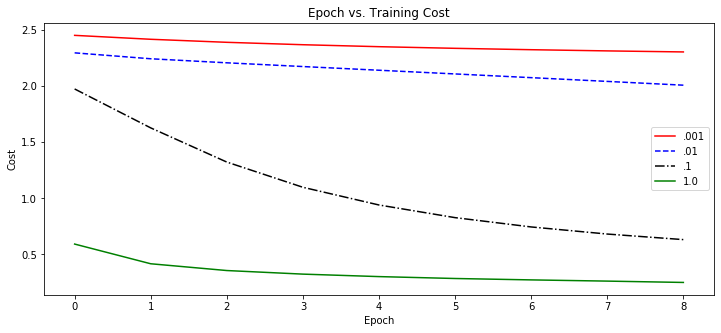

In [138]:
""""Plot cost and accuracy over epochs

    while varying learning rate"""

print("LR: .001")
LR1=mbANN(X_train, Y_train, X_test, Y_test,learning_rate=.001,
      n_h=64,epoch=9, matrix=False) 

print("LR: .01")
LR2=mbANN(X_train, Y_train,X_test,Y_test,learning_rate=.01,
      n_h=64,epoch=9, matrix=False) 

print("LR: .1")
LR3=mbANN(X_train, Y_train, X_test, Y_test,learning_rate=.1,
      n_h=64,epoch=9, matrix=False)

print("LR: 1.0")
LR4=mbANN(X_train, Y_train, X_test, Y_test,learning_rate=1,
      n_h=64,epoch=9, matrix=False)

lr1_epoch = list((zz[0] for zz in LR1))
lr1_accuracy = list((zz[1] for zz in LR1))

lr2_epoch = list((zz[0] for zz in LR2))
lr2_accuracy = list((zz[1] for zz in LR2))

lr3_epoch = list((zz[0] for zz in LR3))
lr3_accuracy = list((zz[1] for zz in LR3))

lr4_epoch = list((zz[0] for zz in LR4))
lr4_accuracy = list((zz[1] for zz in LR4))

plt.figure(figsize=(12,5))
plt.title("Epoch vs. Training Cost")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.plot(lr1_epoch, lr1_accuracy, label=".001", color="red", linestyle= '-')
plt.plot(lr2_epoch, lr2_accuracy, label=".01", color= "blue", linestyle= '--')
plt.plot(lr3_epoch, lr3_accuracy, label= ".1",color= "black", linestyle='-.')
plt.plot(lr4_epoch, lr4_accuracy, label="1.0", color= "green")
plt.legend(loc="best")

plt.show()

## Scikit Learn Comparison

- Let's now compare the model we've built with the built-in Neural Network classifier on Scikit Learn. 
- Let's first run our model and then Scikit's.

LR1:


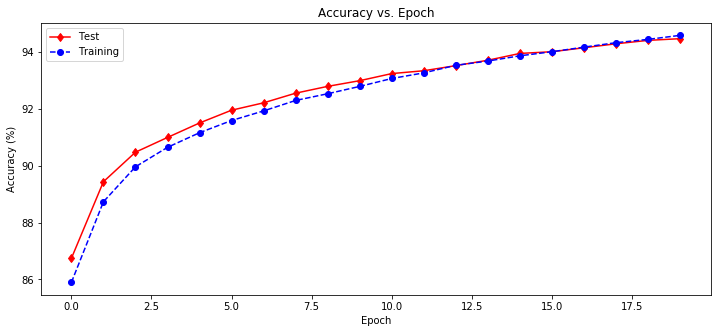

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1011
           1       0.98      0.97      0.98      1152
           2       0.94      0.94      0.94      1027
           3       0.94      0.94      0.94      1017
           4       0.95      0.93      0.94      1000
           5       0.91      0.94      0.93       868
           6       0.96      0.94      0.95       974
           7       0.93      0.95      0.94      1007
           8       0.93      0.94      0.93       959
           9       0.91      0.94      0.92       985

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.95      0.94      0.94     10000



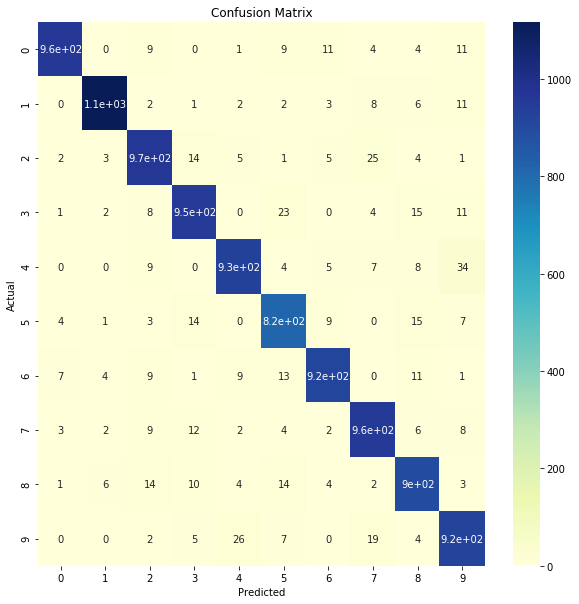

Total Time: 27.51477813720703
Final train cost: 0.1916007272272984         Final test cost: 0.1881438165439915
Done. 



In [139]:
print("LR1:")
LR1=mbANN(X_train, Y_train,X_test,Y_test,
    learning_rate=.9,n_h=75,
    epoch=20, matrix=True, plot=True) 

In [140]:
x1_list=[]
y1_list=[]
for i in range(20):
    x1= LR1[i][0]
    y1= LR1[i][3]
    
    x1_list.append(x1)
    y1_list.append(y1)

### Scikit Learn

- We will be using MLPClassifier function in order to classify our dataset. 

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       998
         1.0       0.99      0.98      0.99      1139
         2.0       0.97      0.96      0.97      1044
         3.0       0.97      0.96      0.97      1018
         4.0       0.97      0.96      0.97       992
         5.0       0.96      0.96      0.96       897
         6.0       0.97      0.97      0.97       961
         7.0       0.97      0.98      0.97      1014
         8.0       0.95      0.98      0.96       947
         9.0       0.95      0.97      0.96       990

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

The accuracy is 97.0%


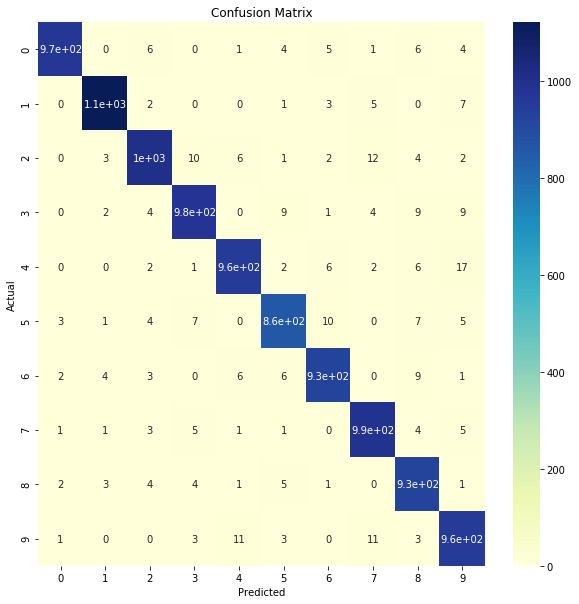

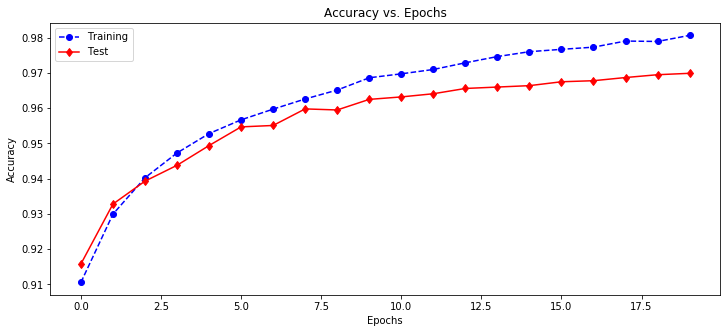

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier
np.random.seed(1)

#reload data
mnist = fetch_mldata("MNIST original")

# rescale the data, use the traditional train/test split
X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=0, tol=1e-8, random_state=1,
                    learning_rate_init=.01)

N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 20
N_BATCH = 128
N_CLASSES = np.unique(y_train)

train_list = []
test_list = []

epoch = 0
while epoch < N_EPOCHS:

    # Shuffle
    random_perm = np.random.permutation(X_train.shape[0])
    mini_batch_index = 0
    while True:

        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    train_list.append(mlp.score(X_train, y_train))
    test_list.append(mlp.score(X_test, y_test))

    epoch += 1

y_predicted = mlp.predict(X_test)

#test the accuracy
accuracy = np.mean(y_test == y_predicted) *100


cm= confusion_matrix(y_predicted, y_test)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(classification_report(y_predicted, y_test))
print("The accuracy is {0:.1f}%".format(accuracy))

plt.figure(figsize=(12,5))
plt.plot(train_list, color='blue',marker='o',linestyle="dashed", label='Training')
plt.plot(test_list, color='red', marker='d', label="Test")
plt.title("Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

Neural Network based on NumPy:


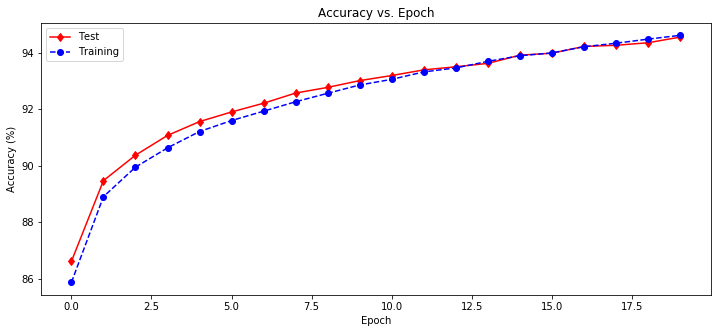

In [142]:
from IPython.display import Image

print("Neural Network based on NumPy:")
Image(filename='testplot.png') 

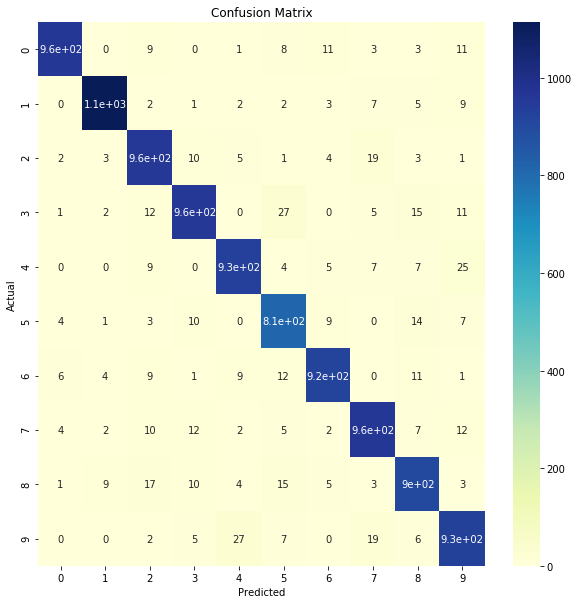

In [143]:
Image(filename='cm.png')

- Comparing the NumPy model with the Scikit learn built-in function, the accuracy between the two are not too far off. However, Scikit's function is about 2% higher.
- If we want our model to be as good as the MLPClassifier, we can further tune other hyperparameters. 